In [32]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt

In [42]:
#hyperparamters
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
input_size = 26 * 26
hidden1_size = 256
hidden2_size = 64
output_size = 10
learning_rate = 0.001

### **Downloading MNIST dataset, making random sampler and setting up transforms for image (Task 0)**

In [34]:
#generating indices for training and validation set
torch.random.manual_seed(1)
validation_indices = torch.randperm(60000)[:6000]
train_indices = torch.tensor([idx for idx in range(60000) if idx not in validation_indices])

torch.manual_seed(1)
train_indices = train_indices[torch.randperm(54000)]

#custom data samplers to separate training and validation set
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(validation_indices)

In [35]:
#transforms, differing only in random crop and center crop
train_transforms = transforms.Compose([transforms.RandomCrop(size=(26, 26)),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5,), std=(0.5,))])

test_transforms = transforms.Compose([transforms.CenterCrop(size=(26, 26)),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5,), std=(0.5,))])


### **Creating Dataloaders and plotting few images for each class (Task 1)**

In [36]:
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               download=True,
                               transform=train_transforms)

valid_dataset = datasets.MNIST(root='data',
                               train=True,
                               download=True,
                               transform=test_transforms)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              download=True,
                              transform=test_transforms)

#Creating data loaders
train_loader = DataLoader(train_dataset,
                          batch_size=256,
                          sampler=train_sampler)

valid_loader = DataLoader(valid_dataset,
                          batch_size=256,
                          sampler=valid_sampler)

test_loader = DataLoader(test_dataset, 
                         batch_size=256, 
                         shuffle=True)

In [70]:
label_arr = np.zeros(10, dtype=np.int16)
img_list = []

for i in range(10):
    for images, labels in train_loader:
        if label_arr[i] == 2:
            break
        for (label, image) in zip(labels, images):
            if label_arr[i] == 2:
                break
            if label == i:
                label_arr[i] += 1
                img_list.append(image.numpy())

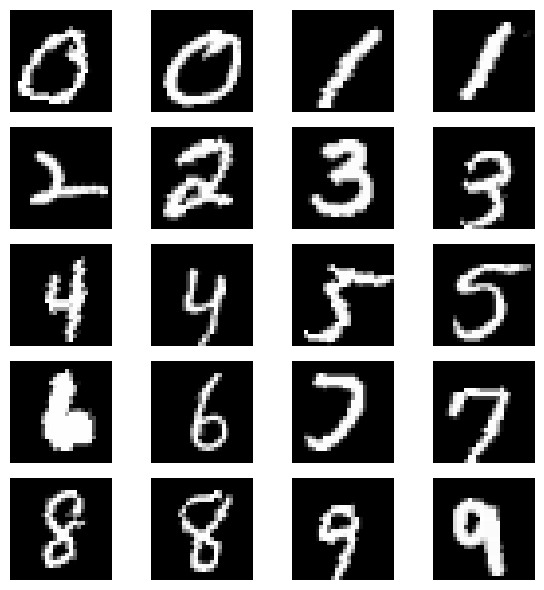

In [73]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(6, 6))

axes = axes.flatten()

for i, image in enumerate(img_list):
    ax = axes[i]
    ax.imshow(image[0], cmap='gray')
    ax.axis('off') 

plt.tight_layout()
# plt.savefig('images/two_images_per_class.png')
plt.show()

### **Implementing the 3 layered MLP and printing number of trainable parameters (Task 2)**

In [65]:
#3 layered MLP class
class ThreeLayeredMLP(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(ThreeLayeredMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        #flattening the image
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [119]:
num_params = sum(p.numel() for p in ThreeLayeredMLP(input_size, hidden1_size, hidden2_size, output_size).parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')

Number of parameters: 190410


### **Writing necessary functions and training for 5 epochs, which includes logging data such as losses and accuracies (Task 3)**

In [66]:
#function to perform epoch wise training
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    total_batches = len(train_loader)

    #getting images and labels from every batch, of batch size = 256
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #performing backpropagation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += compute_accuracy(outputs, labels)

    epoch_loss = running_loss / total_batches
    epoch_accuracy = running_accuracy / total_batches
    return epoch_loss, epoch_accuracy


#function to calculate loss and accuracy for given dataset, model and loss function
def calc_loss_accuracy(model, loader, criterion, device):
    running_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total if total != 0 else 0.0
    return epoch_loss, epoch_acc


#to compute accuracy
def compute_accuracy(outputs, labels):
    predicted = outputs.argmax(dim=1)
    correct = predicted.eq(labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [67]:
#Creating the model, optimizer, and loss function
model = ThreeLayeredMLP(input_size, hidden1_size, hidden2_size, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [68]:
#Training loop
max_acc = 0.0
best_model = None
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(5):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = calc_loss_accuracy(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_acc > max_acc:
        max_acc = val_acc
        best_model = model.state_dict()

    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

torch.save(best_model, 'best_model.pth')

Epoch: 1 | Train Loss: 0.7909 | Val Loss: 0.3848 | Train Acc: 0.7598 | Val Acc: 0.8888
Epoch: 2 | Train Loss: 0.4239 | Val Loss: 0.2549 | Train Acc: 0.8730 | Val Acc: 0.9278
Epoch: 3 | Train Loss: 0.2740 | Val Loss: 0.1737 | Train Acc: 0.9180 | Val Acc: 0.9473
Epoch: 4 | Train Loss: 0.2158 | Val Loss: 0.1585 | Train Acc: 0.9346 | Val Acc: 0.9520
Epoch: 5 | Train Loss: 0.1816 | Val Loss: 0.1509 | Train Acc: 0.9444 | Val Acc: 0.9537


In [69]:
test_loss, test_acc = calc_loss_accuracy(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.1280 | Test Acc: 0.9585


### **Plotting graphs and visualising few correct and incorrect predictions (Task 4)**

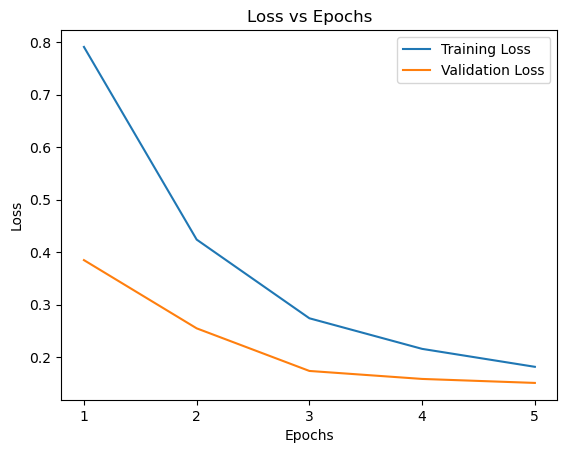

In [125]:
plt.plot(range(1, 6), train_losses, label='Training Loss')
plt.plot(range(1, 6), val_losses, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([1, 2, 3, 4, 5])
plt.legend(loc='best')
plt.title('Loss vs Epochs')
# plt.savefig('images/losses_graph.png')
plt.show()

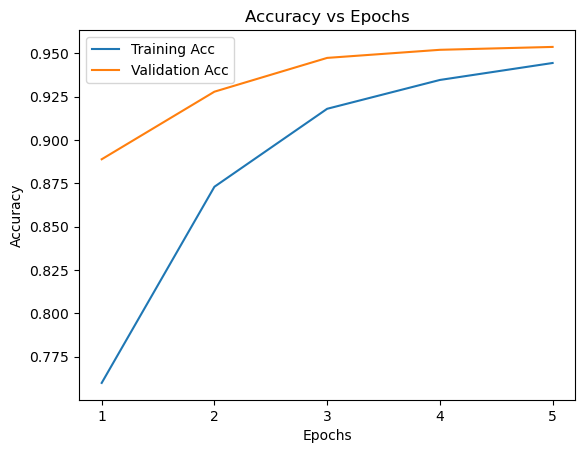

In [124]:
plt.plot(range(1, 6), train_accs, label='Training Acc')
plt.plot(range(1, 6), val_accs, label='Validation Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks([1, 2, 3, 4, 5])
plt.legend(loc='best')
plt.title('Accuracy vs Epochs')
# plt.savefig('images/accuracy_graph.png')
plt.show()

In [109]:
correct_img, correct_labels, misclassified_img, actual_labels, pred_labels = [], [], [], [], []
f=0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        for i in range(len(labels)):
            if (labels[i] == preds[i]):
                if (len(correct_img) < 10):
                    correct_img.append(images[i][0].cpu().numpy())
                    correct_labels.append(labels[i].cpu().item())
            
            else:
                if len(misclassified_img) < 10:
                    misclassified_img.append(images[i][0].cpu().numpy())
                    actual_labels.append(labels[i].cpu().item())
                    pred_labels.append(preds[i].cpu().item())
        
            if (len(correct_img) == 10) and (len(misclassified_img) == 10):
                f=1
                break
        
        if f == 1:
            break

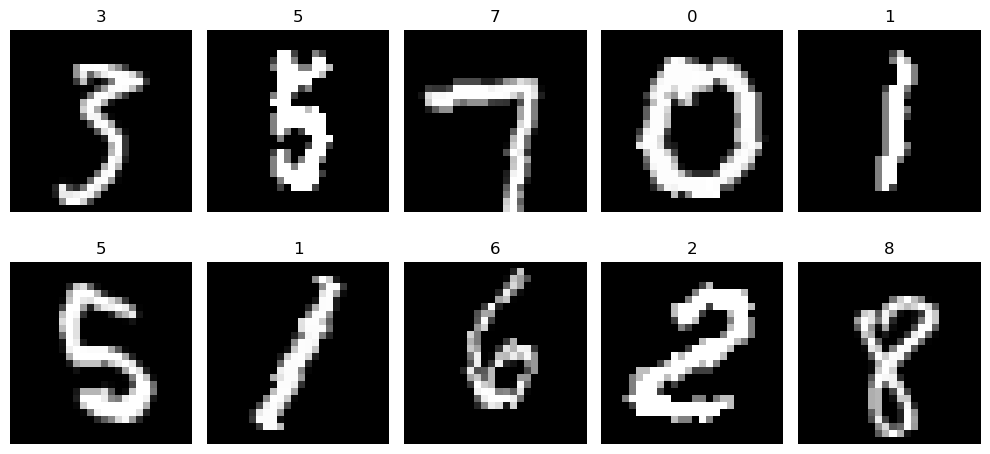

In [113]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(correct_img[i], cmap='gray')
    ax.set_title(f'{labels[i]}')
    ax.axis('off')

plt.tight_layout()
# plt.savefig('images/correct_classify.png')
plt.show()

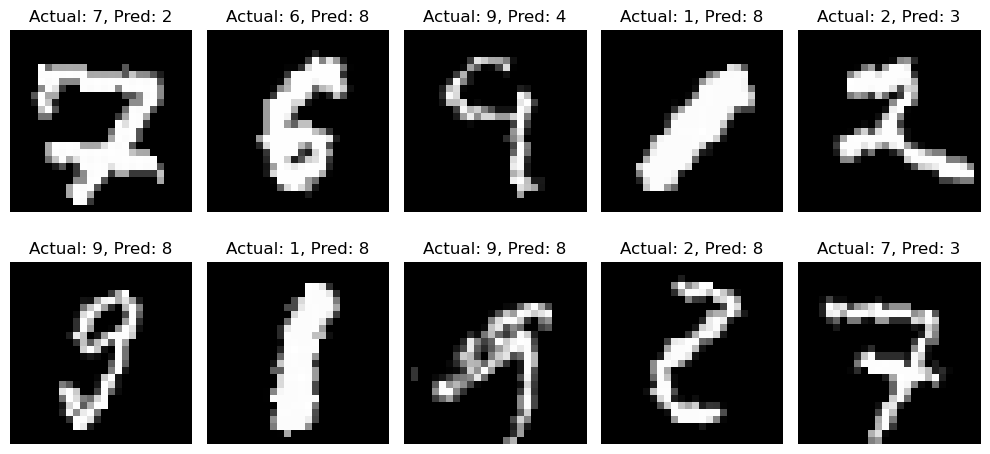

In [114]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(misclassified_img[i], cmap='gray')
    ax.set_title(f'Actual: {actual_labels[i]}, Pred: {pred_labels[i]}')
    ax.axis('off')

plt.tight_layout()
# plt.savefig('images/misclassified.png')
plt.show()